# Business Case: Evaluating AML Risk Through Data Science

## Context & Business Problem
Financial institutions and fintech companies must continuously strengthen their Anti-Money Laundering (AML) detection capabilities to prevent illicit financial activities. AML compliance teams rely on advanced analytics and machine learning to identify suspicious transactions, assess risk, and enhance regulatory reporting.

To evaluate your analytical and problem-solving abilities in feature engineering, risk scoring, anomaly detection, model explainability, and proper data design, you will work on the following problem:
- Cryptocurrency AML Detection: Identifying illicit Bitcoin transactions by analyzing blockchain transaction flows and patterns.


## Crypto AML Detection (Elliptic Bitcoin Dataset)
### Problem Statement
You are part of a cryptocurrency exchange’s risk analytics team. Your goal is to detect illicit Bitcoin transactions associated with money laundering, darknet marketplaces, and other criminal activities. Each transaction is linked to either licit or illicit entities, and you must develop a model that predicts whether a new transaction is likely illicit.
Key Challenges:
- Graph-based Feature Engineering: Extract meaningful features from blockchain
transaction flows.
- Anomaly Detection: Identify patterns that differentiate illicit from licit transactions.
- Explainability: Justify why a given Bitcoin transaction is labeled illicit.
- Scalability: Handle large-scale, network-based financial data.



## Development of the solution"

In [218]:
## Libraries and Inputs
import os
import shap
import joblib
import json
import warnings
import numpy as np
import pandas as pd                                                                             # Manage DataFrames
import networkx as nx                                                                           # Graphs management
import kagglehub                                                                                # Kaggler DataSet Ingestion
import seaborn as sns                                                                           # Visualization
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_kmo                                       # Kaiser Meyer Olkin
from sklearn.preprocessing import RobustScaler                                                  # Scale features
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold           # train test split
from xgboost import XGBClassifier                                                               # xgboost model
from sklearn.ensemble import RandomForestClassifier                                             # Random forest model
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings("ignore")




In [156]:
## Full Dataset Download
path        = kagglehub.dataset_download("ellipticco/elliptic-data-set")
full_path   = os.path.join(path, "elliptic_bitcoin_dataset")
df_features = pd.read_csv(os.path.join(full_path,"elliptic_txs_features.csv"), header=None)
df_edgelist = pd.read_csv(os.path.join(full_path,"elliptic_txs_edgelist.csv"))
df_clases   = pd.read_csv(os.path.join(full_path,"elliptic_txs_classes.csv"))

In [157]:
columnas = ['txId', 'Time_step']
columnas += [f'VAR_P_{i}' for i in range(1, 94)]
columnas += [f'VAR_S_{i}' for i in range(1, 73)]

df_features.columns = columnas

print(df_features.head(5))

        txId  Time_step   VAR_P_1   VAR_P_2   VAR_P_3    VAR_P_4   VAR_P_5  \
0  230425980          1 -0.171469 -0.184668 -1.201369  -0.121970 -0.043875   
1    5530458          1 -0.171484 -0.184668 -1.201369  -0.121970 -0.043875   
2  232022460          1 -0.172107 -0.184668 -1.201369  -0.121970 -0.043875   
3  232438397          1  0.163054  1.963790 -0.646376  12.409294 -0.063725   
4  230460314          1  1.011523 -0.081127 -1.201369   1.153668  0.333276   

    VAR_P_6    VAR_P_7   VAR_P_8  ...  VAR_S_63  VAR_S_64  VAR_S_65  VAR_S_66  \
0 -0.113002  -0.061584 -0.162097  ... -0.562153 -0.600999  1.461330  1.461369   
1 -0.113002  -0.061584 -0.162112  ...  0.947382  0.673103 -0.979074 -0.978556   
2 -0.113002  -0.061584 -0.162749  ...  0.670883  0.439728 -0.979074 -0.978556   
3  9.782742  12.414558 -0.163645  ... -0.577099 -0.613614  0.241128  0.241406   
4  1.312656  -0.061584 -0.163523  ... -0.511871 -0.400422  0.517257  0.579382   

   VAR_S_67  VAR_S_68  VAR_S_69  VAR_S_70  V

In [158]:
print(df_edgelist.head())
print(df_clases.head())

       txId1      txId2
0  230425980    5530458
1  232022460  232438397
2  230460314  230459870
3  230333930  230595899
4  232013274  232029206
        txId    class
0  230425980  unknown
1    5530458  unknown
2  232022460  unknown
3  232438397        2
4  230460314  unknown


### Exploratory Analysis

- The dataset is highly imbalanced, with the following class distribution:
    - Illicit: 4,545
    - Licit: 42,019
    - Unknown: 157,205

- All features are complete, with no missing values detected.

- 136 features contain outliers, ranging from 82,000 to 42 outlier observations per feature. Since the exact nature of these outliers is unknown, we opted to retain all records for modeling.

- While there is moderate correlation among features, the overall KMO score is 0.64, which is not strong enough to justify dimensionality reduction using PCA.


class
1            4545
2           42019
unknown    157205
dtype: int64
               txId      Time_step       VAR_P_1       VAR_P_2       VAR_P_3  \
count  2.037690e+05  203769.000000  2.037690e+05  2.037690e+05  2.037690e+05   
mean   1.711310e+08      23.843961  2.454849e-17 -7.531922e-18  2.231681e-17   
std    1.104655e+08      15.172170  1.000002e+00  1.000002e+00  1.000002e+00   
min    1.076000e+03       1.000000 -1.729826e-01 -2.105526e-01 -1.756361e+00   
25%    8.433452e+07       9.000000 -1.725317e-01 -1.803266e-01 -1.201369e+00   
50%    1.624375e+08      23.000000 -1.692045e-01 -1.328975e-01  4.636092e-01   
75%    2.454798e+08      38.000000 -1.318553e-01 -5.524241e-02  1.018602e+00   
max    4.032446e+08      49.000000  7.168197e+01  7.359505e+01  2.683580e+00   

            VAR_P_4       VAR_P_5       VAR_P_6       VAR_P_7       VAR_P_8  \
count  2.037690e+05  2.037690e+05  2.037690e+05  2.037690e+05  2.037690e+05   
mean   6.241732e-17  7.653968e-17  5.858162e-17 

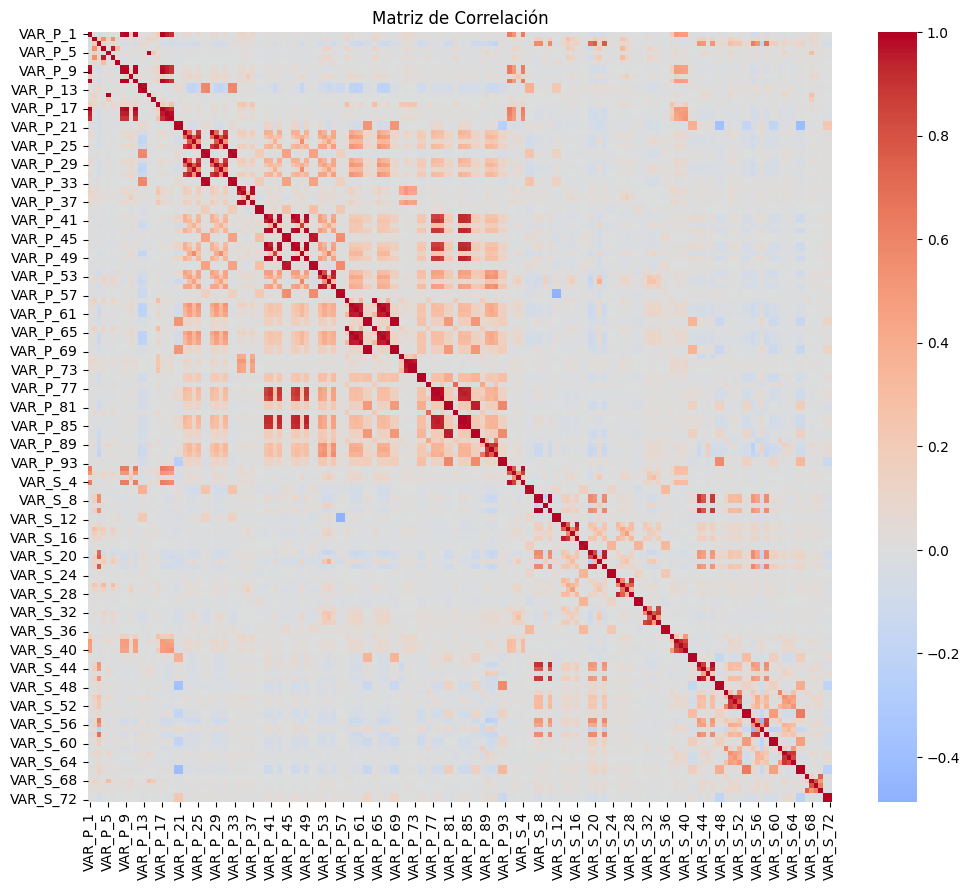

KMO general: 0.641


In [159]:
############################## Classes balance
print(df_clases.groupby('class').size())
############################## Features description
print(df_features.describe())
############################## Null Count
print(df_features.isnull().sum()[df_features.isnull().sum() > 0])
############################## Outliers
outliers = {}

for col in df_features.select_dtypes(include='number').columns:
    Q1 = df_features[col].quantile(0.25)
    Q3 = df_features[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = (df_features[col] < Q1 - 1.5 * IQR) | (df_features[col] > Q3 + 1.5 * IQR)
    outliers[col] = outlier_mask.sum()

# Convertir a DataFrame para ver columnas con outliers
outliers_df = pd.DataFrame.from_dict(outliers, orient='index', columns=['n_outliers'])
outliers_df = outliers_df[outliers_df['n_outliers'] > 0].sort_values(by='n_outliers', ascending=False)
print("-----------------------------------------------------------------------------------------------------------------------")
print(max(outliers_df['n_outliers']), min(outliers_df['n_outliers']))
print(outliers_df.head(136))
############################## Correlation
correlation_matrix = df_features.iloc[:, 2:].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

kmo_all, kmo_model = calculate_kmo(df_features.iloc[:, 2:])
print(f"KMO general: {kmo_model:.3f}")

In [ ]:
################################################## Graph built
G = nx.from_pandas_edgelist(df_edgelist, 'txId1', 'txId2', create_using=nx.DiGraph)
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

label_dict = dict(zip(df_clases['txId'], df_clases['class']))

# Asignar color por categoría
def get_node_color(node):
    label = label_dict.get(node, 'unknown')
    if label == '1':
        return 'red'
    elif label == '2':
        return 'green'
    else:
        return 'lightgray'

# Lista de colores para los nodos del subgrafo
color_map = [get_node_color(n) for n in G.nodes()]

# Dibujar
plt.figure(figsize=(12, 10))
nx.draw(G, node_color=color_map, node_size=50, edge_color='lightblue', with_labels=False)
plt.title("Transaction Graph - Illicit (Red), Licit (Green), Unknown (Gray)")
#plt.show()

### Feature Engineering



Findings:
- The transaction graph is composed of 49 weakly connected components, which aligns with the timestep variable. Each component corresponds to a distinct time slice of the Bitcoin network.

New Features and Their Relevance to Illicit Transaction Detection:
 - **Degree**: Indicates how many direct connections a transaction has. A very high degree might reflect a transaction involved in a dense cluster, possibly signaling suspicious aggregation or distribution behavior.
 - **In-Degree**: Represents how many transactions send funds to a given node. A high in-degree may indicate structuring activity, where funds are being collected from multiple sources.
 - **Out-Degree**: Shows how many transactions receive funds from a given node. A high out-degree could signal layering, where a node disperses funds to multiple destinations to obscure origin.
 - **Subgraph Size**: The number of nodes in the connected component the transaction belongs to. Smaller components might represent isolated, possibly anomalous behavior, while larger components could reveal broader laundering networks.
 - **Closeness Centrality**: Measures how quickly a node can reach all others in the graph. Transactions with high closeness might sit in key positions within the network, allowing rapid flow of funds, potentially reflecting illicit coordination.
 - **Betweenness Centrality**: Captures how often a node lies on the shortest paths between others. Nodes with high betweenness can act as intermediaries or funnels, which are typical roles in laundering chains.
 - **Eigenvector Centrality**: Scores nodes based on the influence of their neighbors. Transactions connected to other influential (possibly high-risk) nodes might themselves be suspicious.
 - **PageRank**: Reflects the likelihood that a transaction will be reached during a random walk through the graph. Higher PageRank values may correspond to highly visited or attractive destinations.



#### Feature Creation

In [161]:
################################################## Subgraph size
components = list(nx.weakly_connected_components(G))

component_size_map = {}
for component in components:
    size = len(component)
    for node in component:
        component_size_map[node] = size
################################################## Centrality measures

eigenvector = nx.eigenvector_centrality(G, max_iter=500, tol=1e-06)
# PageRank
pagerank = nx.pagerank(G, alpha=0.85)
# Betweenness (aproximación para mejorar tiempo)
betweenness = nx.betweenness_centrality(G, k=1000, seed=42)
# Closeness centrality
closeness = nx.closeness_centrality(G)

################################################## Features df built
# Convertir a DataFrame si lo quieres analizar mejor
df_features_2 = pd.DataFrame({
    "node": list(G.nodes()),
    "degree": [G.degree(n) for n in G.nodes()],
    "in_degree": [G.in_degree(n) for n in G.nodes()],
    "out_degree": [G.out_degree(n) for n in G.nodes()],
    "component_size": [component_size_map[n] for n in G.nodes()],
    "pagerank": [pagerank.get(n, 0) for n in G.nodes()],
    "betweenness": [betweenness.get(n, 0) for n in G.nodes()],
    "closeness": [closeness.get(n, 0) for n in G.nodes()],
    "eigenvector": [eigenvector[n] for n in G.nodes()]

})
df_features_2.head()

,node,degree,in_degree,out_degree,component_size,pagerank,betweenness,closeness,eigenvector
0,230425980,2,1,1,7880,0.000005,0.000000e+00,0.000009,7.284578e-18
1,5530458,2,1,1,7880,0.000006,0.000000e+00,0.000009,2.248997e-17
2,232022460,3,1,2,7880,0.000007,0.000000e+00,0.000007,1.175815e-20
3,232438397,161,160,1,7880,0.000351,1.226898e-07,0.000887,2.693585e-15
4,230460314,10,2,8,7880,0.000002,0.000000e+00,0.000011,1.409627e-20


#### Feature transformation

Strategy

- Most of the numerical features exhibit skewed distributions, which could potentially be addressed by applying a logarithmic transformation followed by standardization. However, to simplify preprocessing and better handle outliers and non-Gaussian distributions, we chose to apply Robust Scaling, which centers the data using the median and scales it based on the interquartile range (IQR). This approach is well-suited for features with heavy skew and extreme values.

- The Time_step variable represents discrete time intervals in the dataset and is treated as a nominal categorical feature, despite being represented with numeric values ranging from 1 to 49. Since these values do not carry a true ordinal or continuous meaning, we applied one-hot encoding to prevent the model from interpreting the numerical representation as indicative of magnitude or order. 

In [162]:
df_features_all = df_features.merge(df_features_2, left_on="txId", right_on="node", how="left")
df_features_all = df_features_all.drop(columns=["node"])
scaler = RobustScaler()

no_scale = df_features_all.iloc[:, :2]
yes_scale = df_features_all.iloc[:, 2:]

a_escalar_scaled = pd.DataFrame(
    scaler.fit_transform(yes_scale),
    columns=[f"{col}_scaled" for col in yes_scale.columns],
    index=df_features_all.index
)

# One hot encoding categorical nominal variable
no_scale = pd.get_dummies(no_scale, columns=["Time_step"], prefix="T", drop_first=True)

# Concatenar columnas originales (no escaladas) con las escaladas
df_features_all_scaled = pd.concat([no_scale, a_escalar_scaled], axis=1)

df_features_all_scaled.head()


,txId,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9,T_10,...,VAR_S_71_scaled,VAR_S_72_scaled,degree_scaled,in_degree_scaled,out_degree_scaled,component_size_scaled,pagerank_scaled,betweenness_scaled,closeness_scaled,eigenvector_scaled
0,230425980,False,False,False,False,False,False,False,False,False,...,0.000000,0.000000,0.0,0.0,0.0,1.404632,0.312491,0.000000e+00,0.215517,7.283368e-18
1,5530458,False,False,False,False,False,False,False,False,False,...,0.000000,0.000000,0.0,0.0,0.0,1.404632,0.624981,0.000000e+00,0.229885,2.248876e-17
2,232022460,False,False,False,False,False,False,False,False,False,...,0.000000,0.000000,1.0,0.0,1.0,1.404632,0.988287,0.000000e+00,0.086207,1.054753e-20
3,232438397,False,False,False,False,False,False,False,False,False,...,0.000000,0.000000,159.0,159.0,0.0,1.404632,83.729739,1.226898e-07,92.751179,2.693584e-15
4,230460314,False,False,False,False,False,False,False,False,False,...,1.095845,1.246685,8.0,1.0,7.0,1.404632,-0.226689,0.000000e+00,0.474138,1.288565e-20


#### Feature Selection

Strategy

 - To select the most relevant features, we will build a model and evaluate each variable based on its predictive importance. We will use tree-based models such as XGBoost, Random Forest, or Gradient Boosting (sklearn), as these are less sensitive to class imbalance and skewed feature distributions compared to models like logistic regression, which rely on assumptions (e.g., linearity and normality) that are not satisfied in this dataset.

We select the top 30 variables by predictive importance it gave the best AUC over the whole data.  



In [236]:
# Map class
df_features_m1 = df_features_all_scaled.merge(df_clases, on='txId', how='inner')
df_features_m1

# Filter just Licit Illicit
df_model_1 = df_features_m1[df_features_m1["class"].isin(["1", "2"])].copy()
df_model_1["target"] = (df_model_1["class"] == "1").astype(int)  # 1: illicit, 0: licit
df_model_1.set_index('txId', inplace=True)

# Define Model Inputs
exclude = ['txId', 'target', 'class']
features = [col for col in df_model_1.columns if col not in exclude]

X = df_model_1[features]
#X = X.iloc[:,-8:]
y = df_model_1["target"]

# Balance class imbalance
neg = sum(y == 0)
pos = sum(y == 1)
scale = neg / pos
print(f"scale_pos_weight: {scale:.2f}")

# Train
model_1 = XGBClassifier(scale_pos_weight=scale, use_label_encoder=False, eval_metric='logloss')
model_1.fit(X, y)

# Feature predictive importance
importances = pd.Series(model_1.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

sum(importances[:30])

scale_pos_weight: 9.25


0.7629436524584889

In [237]:
scores = []
for n in range(5, 151, 5):  # de 5 a 50 en pasos de 5
    selected = importances.head(n).index.tolist()
    X_sel = X[selected]
    model = XGBClassifier(scale_pos_weight=scale, use_label_encoder=False, eval_metric='logloss')
    score = cross_val_score(model, X_sel, y, scoring='roc_auc', cv=5).mean()
    scores.append((n, score))
n, score = max(scores, key=lambda x: x[1])
print(n, score)

30 0.9753944533669416


In [282]:
selected = importances.head(30).index.tolist()
Xtop_30 = X[selected]

### Model Selection
#### Model train & test

We trained both XGBoost and Random Forest models and evaluated their performance to determine the most suitable model for this task.

We selected XGBoost as the final model. Although it shows slightly lower precision compared to Random Forest, this is acceptable since false positives can be reviewed by the investigations team. More importantly, XGBoost achieves a higher recall (0.94), meaning it misses fewer illicit transactions — a crucial factor in anti-money laundering scenarios where detecting as many suspicious cases as possible is the top priority.




In [239]:
X_train, X_test, y_train, y_test = train_test_split(Xtop_30, y, test_size=0.2, stratify=y, random_state=42)

# Calcular scale_pos_weight para XGBoost
scale = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(scale_pos_weight=scale, eval_metric='logloss', use_label_encoder=False, random_state=42)
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)

xgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

print("XGBoost")
y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb, target_names=['Licit', 'Illicit']))

print("Random Forest")
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=['Licit', 'Illicit']))

XGBoost
              precision    recall  f1-score   support

       Licit       0.99      1.00      0.99      8404
     Illicit       0.96      0.94      0.95       909

    accuracy                           0.99      9313
   macro avg       0.98      0.97      0.97      9313
weighted avg       0.99      0.99      0.99      9313

Random Forest
              precision    recall  f1-score   support

       Licit       0.99      1.00      0.99      8404
     Illicit       0.99      0.88      0.93       909

    accuracy                           0.99      9313
   macro avg       0.99      0.94      0.96      9313
weighted avg       0.99      0.99      0.99      9313



In [240]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_model, X_train, y_train, scoring='roc_auc', cv=cv)
print("Cross-validated AUC scores (train set):", scores)
print("Mean AUC:", scores.mean())

Cross-validated AUC scores (train set): [0.99219119 0.99629329 0.99728948 0.99737316 0.99821651]
Mean AUC: 0.9962727264911241


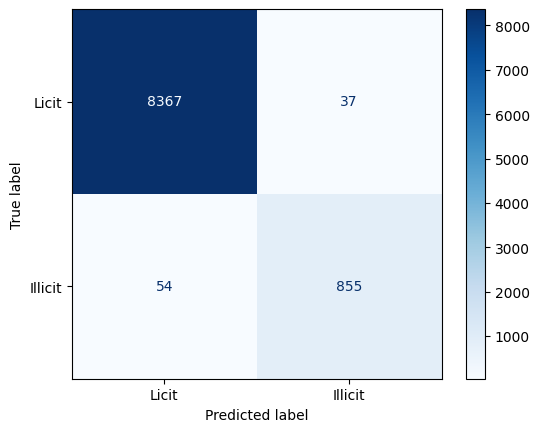

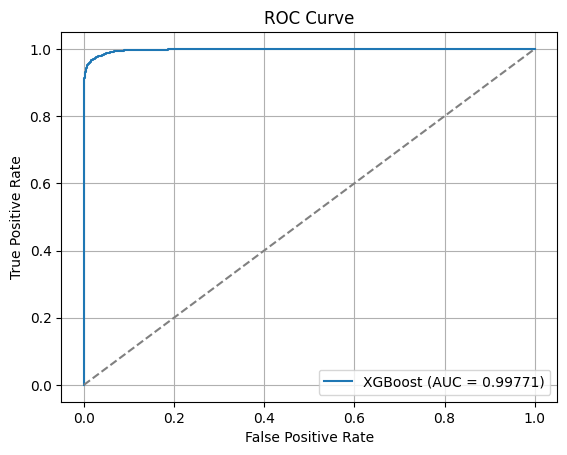

In [241]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(cm, display_labels=['Licit', 'Illicit'])
disp.plot(cmap='Blues')

y_proba = xgb_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

### Model Explainability

Strategy

 - We will identify the key behavioral patterns of the features driving the classification of illicit transactions.

 - Additionally, we will propose a risk categorization scheme for transactions labeled as illicit:

    - High Risk: Probability > 80%
    - Medium Risk: Probability between 40% and 80%
    - Low Risk: Probability < 40%

<table border="1" class="dataframe">
<thead>
<tr style="text-align: right;">
<th>risk_level</th><th>target</th><th>count</th>
</tr>
</thead>
<tbody>
<tr>
<td>High</td><td>0</td><td>9</td></tr><tr>
<td>High</td><td>1</td><td>829</td></tr><tr>
<td>Low </td><td>0</td><td>8352</td></tr><tr>
<td>Low </td><td>1</td><td>50</td></tr><tr>
<td>Medium</td><td>0</td><td>43</td></tr><tr>
<td>Medium</td><td>1</td><td>30</td></tr>
</tbody>
</table>

We observe in the table that the High Risk category is performing well, as it captures the majority of illicit transactions, although it includes 9 licit transactions(false positives) these can be further investigated before deciding whether to file a SAR. The Medium Risk category appears more ambiguous, as it includes both illicit and a notable number of licit transactions; this suggests an opportunity to fine-tune the model to improve its precision in this range. Finally, the Low Risk category correctly captures most licit transactions, as expected, but it also includes 50 illicit transactions that the model fails to identify, representing a key area for improvement. 

Regarding the model’s explainability in terms of feature importance, we observe that the top 9 features have the most significant impact on the predictions. Notably, 8 out of these 9 features are related to the local characteristics of each transaction, while only one is derived from information about neighboring nodes. Interestingly, no centrality measure appears to have a strong influence on the model. Even though eigenvector centrality—which captures a node’s importance based on its neighbors—ranks within the top 30 features, its impact on predictions is relatively minor.

Examples of features with a clear effect on the model’s output include:

 - Var_P_59: Higher values increase the likelihood of a transaction being classified as illicit.
 - Var_P_53: Also has a positive contribution to illicit classification, though with less intensity.
 - Var_P_29: Exhibits a similar pattern.
 - Var_P_46: In contrast, higher values are associated with a lower probability of the transaction being illicit.

Finally, we included the top 5 features for each prediction that most influenced the model’s classification decision

In [244]:
# Get the probability of each node to be an illict txn
def classify_risk(score):
    if score > 0.80:
        return 'High'
    elif score > 0.40:
        return 'Medium'
    else:
        return 'Low'
    
y_proba = xgb_model.predict_proba(X_test)[:, 1]

df_risk = pd.DataFrame({'node': X_test.index,'risk_score': y_proba})

# Clasify each node by the probability risk of being Illicit
df_risk['risk_level'] = df_risk['risk_score'].apply(classify_risk)

y_test_f = y_test.reset_index()
df_risk_final = df_risk.merge(y_test_f, left_on='node', right_on='txId', how='left')
df_risk_final.drop(columns=["txId"], inplace=True)

print(df_risk_final.head())
print("------------------")
print(df_risk_final.groupby(['risk_level','target']).size().reset_index(name='count'))

df_risk_final.loc[(df_risk_final['risk_level'] == 'Low') & (df_risk_final['target'] == 1),['risk_score'] ].min()


        node  risk_score risk_level  target
0  378233072    0.000072        Low       0
1   96311806    0.161180        Low       0
2  299045648    0.045017        Low       0
3  115922894    0.000021        Low       0
4   99631433    0.000218        Low       0
------------------
  risk_level  target  count
0       High       0      9
1       High       1    829
2        Low       0   8352
3        Low       1     50
4     Medium       0     43
5     Medium       1     30


risk_score    0.000509
dtype: float32

100%|===================| 9267/9313 [00:36<00:00]        

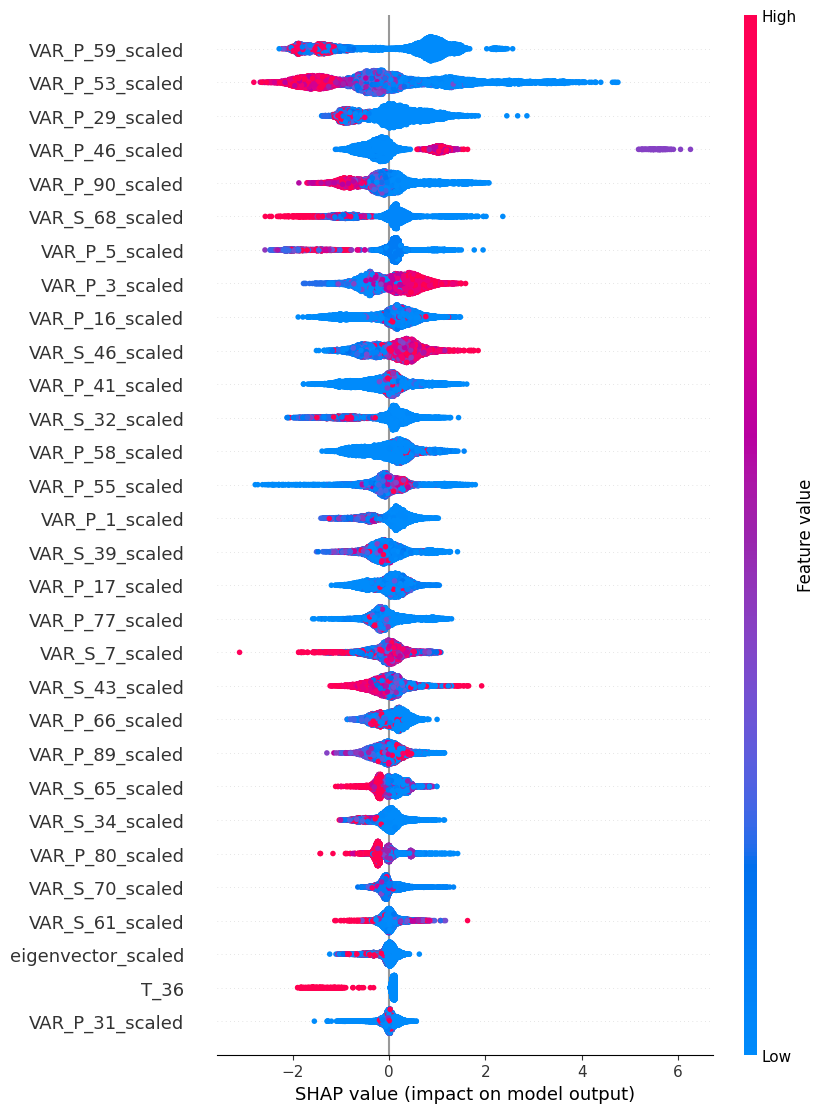

In [245]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)
explainer = shap.Explainer(xgb_model, X_train)  
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=30)

In [246]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

feature_names = X_test.columns

def get_top5_shap(shap_row):
    top5_idx = np.argsort(np.abs(shap_row))[-5:][::-1]
    return [feature_names[i] for i in top5_idx]

top5_features_list = [get_top5_shap(shap_row) for shap_row in shap_values]
df_risk_final['top5_features'] = top5_features_list
df_risk_final.head()

,node,risk_score,risk_level,target,top5_features
0,378233072,0.000072,Low,0,"[VAR_P_90_scaled, VAR_S_68_scaled, VAR_S_32_sc..."
1,96311806,0.161180,Low,0,"[VAR_P_53_scaled, VAR_P_3_scaled, VAR_P_29_sca..."
2,299045648,0.045017,Low,0,"[VAR_P_53_scaled, VAR_P_41_scaled, VAR_P_55_sc..."
3,115922894,0.000021,Low,0,"[VAR_P_59_scaled, VAR_P_29_scaled, VAR_P_53_sc..."
4,99631433,0.000218,Low,0,"[VAR_P_1_scaled, VAR_P_80_scaled, VAR_S_68_sca..."


### Model packaging

In [289]:
# Save the model
joblib.dump(xgb_model, 'xgb_illicit_model.pkl')
# Save features used
with open('xgb_feature_list.json', 'w') as f:
    json.dump(list(X_train.columns.str.replace('_scaled$', '', regex=True)), f)
# Save Robust Scaler
scaler = RobustScaler()
selected_orig = [col.replace('_scaled', '') if col.endswith('_scaled') else col for col in selected]
selected_orig.remove('T_36')
Xtop_30_scaled = scaler.fit_transform(yes_scale[selected_orig])
joblib.dump(scaler, 'scaler_top30.pkl')
# New data example '
df_original_features = df_features_all.merge(no_scale, on='txId', how='left')
df_original_features = df_original_features.drop(columns='Time_step')

print(df_original_features.loc[df_original_features['txId'] == 67673076])
df_original_features.loc[df_original_features['txId'] == 67673076].to_csv("new_data.csv", index=False)

            txId   VAR_P_1   VAR_P_2   VAR_P_3   VAR_P_4   VAR_P_5   VAR_P_6  \
137950  67673076 -0.171603  0.320833  1.573595  0.403293 -0.043875  0.474034   

         VAR_P_7   VAR_P_8  VAR_P_9  ...   T_40   T_41   T_42   T_43   T_44  \
137950 -0.061584 -0.163585 -0.16918  ...  False  False  False  False  False   

         T_45   T_46   T_47   T_48   T_49  
137950  False  False  False  False  False  

[1 rows x 222 columns]


In [292]:
# Load model and preprocessing components
def load_artifacts():
    model = joblib.load('xgb_illicit_model.pkl')
    scaler = joblib.load('scaler_top30.pkl')
    with open('xgb_feature_list.json') as f:
        feature_list = json.load(f)
    return model, scaler, feature_list

# Clasify risk
def classify_risk(score):
    if score > 0.80:
        return 'High'
    elif score > 0.40:
        return 'Medium'
    else:
        return 'Low'

# Predict on new data
def predict_illicit(df_new_raw):
    model, scaler, feature_list = load_artifacts()

    # Check if all required features exist
    missing = [f for f in feature_list if f not in df_new_raw.columns]
    if missing:
        raise ValueError(f"Missing features in input data: {missing}")

    df_new = df_new_raw[feature_list].copy()
    t_columns = [col for col in df_new.columns if col.startswith("T_")]
    non_t_columns = [col for col in df_new.columns if col not in t_columns]
    scaled_non_t = scaler.transform(df_new[non_t_columns])
    df_scaled_non_t = pd.DataFrame(scaled_non_t, columns=non_t_columns, index=df_new.index)

    df_combined = pd.concat([df_scaled_non_t, df_new[t_columns]], axis=1)
    df_combined = df_combined[feature_list]

    df_scaled = df_combined.values

    # Predict probabilities and labels
    prob = model.predict_proba(df_scaled)[:, 1]
    pred = model.predict(df_scaled)

    # SHAP explanation
    df_scaled = df_scaled.astype(float)
    explainer = shap.Explainer(model, df_scaled)
    shap_values = explainer(df_scaled)

    # get top 5 features
    def get_top5_shap(shap_row):
        top5_idx = np.argsort(np.abs(shap_row))[-5:][::-1]
        return [feature_list[i] for i in top5_idx]

    top5_features_list = [", ".join(get_top5_shap(row)) for row in shap_values.values]
    risk_levels = [classify_risk(score) for score in prob]

    # Output DataFrame
    result = pd.DataFrame({
        'txId': df_new_raw.index if df_new_raw.index.name else df_new_raw.reset_index().iloc[:, 0],
        'prob_illicit': prob,
        'prediction': pred,
        'risk_level': risk_levels,
        'top_features': top5_features_list
    })

    return result

if __name__ == '__main__':
    df_example = pd.read_csv('new_data.csv') # Must contain the calculation of the 30 features used
    results = predict_illicit(df_example)
    print(results.head())

   txId  prob_illicit  prediction risk_level  \
0     0       0.40871           0     Medium   

                                        top_features  
0  eigenvector, VAR_S_39, VAR_S_65, VAR_P_3, VAR_S_7  
